# TRO-based Nonlinear Transport Closure Prototype

This notebook demonstrates:
• Constraint-weighted transport closure
• Nonlinear suppression of effective transport χ_eff(λ, g)
• Gradient elasticity collapse under constraint activation
• Embedding of the closure in a 1D diffusion surrogate

This is a structural prototype, not a plasma transport model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


## 1) TRO-style closure: $\chi_{\rm eff}(\lambda,g)$

Define:
- admissible event sizes $s_0$ (heavy-tailed surrogate)
- gradient scaling $s(g)=s_0\,(g/g_0)^\beta$
- penalty $\Delta\Phi=s^q$
- transport increment proxy $\Delta M=s^2$

$$\chi_{\rm eff}(\lambda,g)=\frac{1}{2\Delta t}\,\mathbb{E}_{P_\lambda}[s(g)^2],\quad P_\lambda(e)\propto e^{-\lambda s(g)^q}.$$

In [7]:
def chi_eff_from_sizes(lambda_val, s, q=2.0, dt=1.0):
    """Effective diffusivity proxy via TRO-style softmax weighting."""
    s = np.asarray(s, dtype=float)
    dphi = np.power(s, q)
    x = -float(lambda_val) * dphi
    x = x - np.max(x)
    w = np.exp(x)
    w_sum = float(np.sum(w))
    if w_sum <= 0:
        return 0.0
    p = w / w_sum
    dM = s**2
    return float((1.0/(2.0*float(dt))) * np.sum(p * dM))

# base admissible event sizes
N_EVENTS = 4000
MU, SIGMA = 0.0, 1.0
s0 = np.random.lognormal(mean=MU, sigma=SIGMA, size=N_EVENTS)

def chi_eff(lambda_val, g, g0=1.0, beta=1.0, q=2.0, dt=1.0):
    scale = (max(float(g), 1e-12) / float(g0)) ** float(beta)
    s = s0 * scale
    return chi_eff_from_sizes(lambda_val, s, q=q, dt=dt)


### Plot: stiffness + suppression
Key bridge: $\chi_{\rm eff}$ rises with $g$ (stiffness) but is suppressed by $\lambda$.


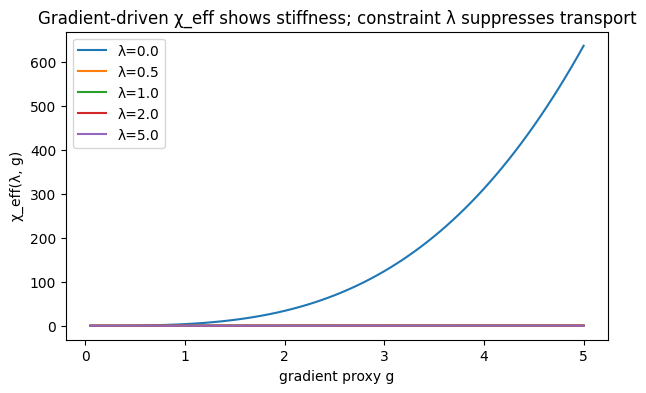

In [8]:
g_vals = np.linspace(0.05, 5.0, 80)
lambda_list = [0.0, 0.5, 1.0, 2.0, 5.0]
BETA, Q = 1.6, 3.0

plt.figure(figsize=(7,4))
for lam in lambda_list:
    chi_vals = [chi_eff(lam, g, beta=BETA, q=Q) for g in g_vals]
    plt.plot(g_vals, chi_vals, label=f"λ={lam}")
plt.xlabel("gradient proxy g")
plt.ylabel("χ_eff(λ, g)")
plt.title("Gradient-driven χ_eff shows stiffness; constraint λ suppresses transport")
plt.legend()
plt.show()


## 2) Stable 1D diffusion surrogate (implicit step)

Evolve scalar profile $p(r,t)$:
$$\partial_t p = \partial_r(\chi(t)\,\partial_r p) + S(r,t).$$

Drive maintains gradients: **core heating + edge loss**.
Regulator (structural): $\dot\lambda = a\,\chi\,g^2 - b\lambda$, where $g=\max_r|\partial_r p|$.


In [15]:
def build_neumann_laplacian(n, dr):
    L = np.zeros((n, n), dtype=float)
    for i in range(1, n-1):
        L[i, i-1] = 1.0
        L[i, i]   = -2.0
        L[i, i+1] = 1.0
    L[0, 0] = -2.0
    L[0, 1] = 2.0
    L[n-1, n-1] = -2.0
    L[n-1, n-2] = 2.0
    return L / (dr**2)

def evolve_profile_implicit(
    nr=200, Tsteps=2400, dt=1e-2,
    lambda0=0.2, a=20.0, b=0.15, c=0.05,
    beta=1.6, q=3.0,
    drive_amp=3.5, drive_ramp=1200,
    chi_cap=20.0,
    edge_loss_coeff=1.3
):
    r = np.linspace(0, 1, nr)
    dr = r[1] - r[0]
    L = build_neumann_laplacian(nr, dr)
    I = np.eye(nr)

    p = np.exp(-((r-0.30)/0.08)**2)

    S_core = np.exp(-((r-0.25)/0.06)**2)
    S_edge = np.exp(-((r-0.95)/0.03)**2)
    S_shape = 1.0*S_core - float(edge_loss_coeff)*S_edge

    lam = float(lambda0)
    chi_hist, lam_hist, g_hist = [], [], []
    snaps = []

    for k in range(Tsteps):
        dpdr = np.gradient(p, dr)
        g = float(np.max(np.abs(dpdr)))
        g_hist.append(g)

        chi = chi_eff(lam, g, beta=beta, q=q, dt=dt)
        chi = float(min(chi, chi_cap))
        chi_hist.append(chi)

        amp = float(drive_amp) * min(1.0, k / max(1, int(drive_ramp)))
        S = amp * S_shape

        dlam = float(a) * chi * (g**2) - float(b) * lam - float(c) * (lam**2)
        lam = max(0.0, lam + float(dt) * dlam)
        lam_hist.append(lam)

        A = I - float(dt) * chi * L
        rhs = p + float(dt) * S
        p = np.linalg.solve(A, rhs)
        p = np.clip(p, 0, None)

        if k in (0, int(Tsteps*0.25), int(Tsteps*0.5), int(Tsteps*0.75), Tsteps-1):
            snaps.append((k*dt, p.copy()))

    return r, snaps, np.array(chi_hist), np.array(lam_hist), np.array(g_hist)


## 3) Run + plots (baseline)


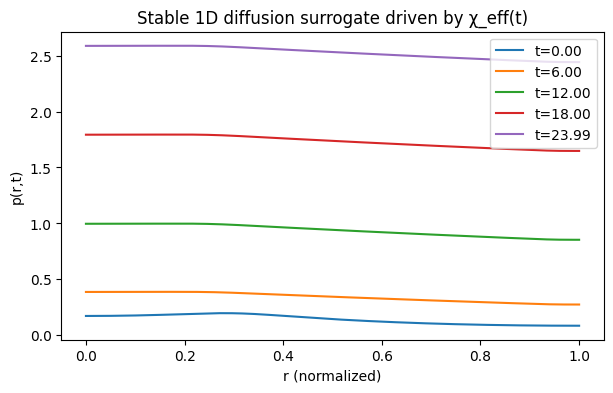

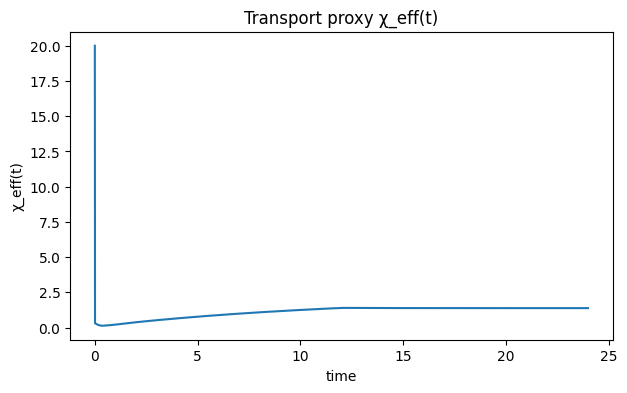

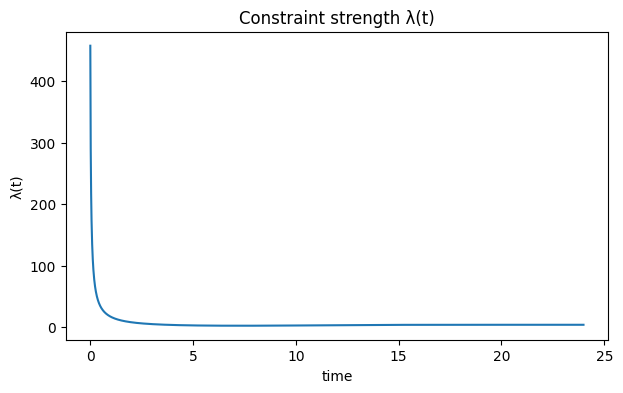

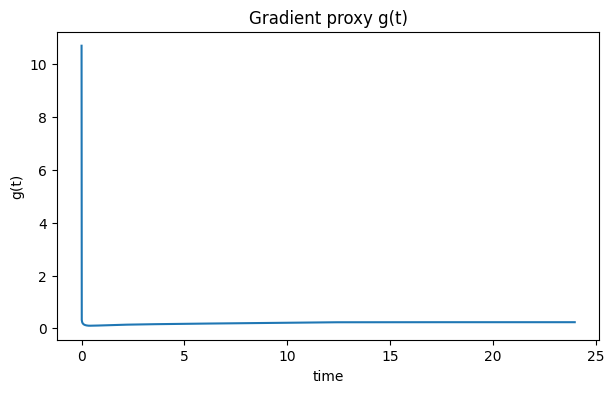

In [20]:
r, snaps, chi_hist, lam_hist, g_hist = evolve_profile_implicit()

plt.figure(figsize=(7,4))
for tt, p_snap in snaps:
    plt.plot(r, p_snap, label=f"t={tt:.2f}")
plt.xlabel("r (normalized)")
plt.ylabel("p(r,t)")
plt.title("Stable 1D diffusion surrogate driven by χ_eff(t)")
plt.legend()
plt.show()

t = np.arange(len(chi_hist))*1e-2  # dt

plt.figure(figsize=(7,4))
plt.plot(t, chi_hist)
plt.xlabel("time")
plt.ylabel("χ_eff(t)")
plt.title("Transport proxy χ_eff(t)")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(t, lam_hist)
plt.xlabel("time")
plt.ylabel("λ(t)")
plt.title("Constraint strength λ(t)")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(t, g_hist)
plt.xlabel("time")
plt.ylabel("g(t)")
plt.title("Gradient proxy g(t)")
plt.show()


## 4) Threshold-hunt presets (optional)
Uncomment one preset, run it, then re-run the plotting cell above.


In [6]:
# Preset A: stronger feedback, lower damping
# r, snaps, chi_hist, lam_hist, g_hist = evolve_profile_implicit(
#     lambda0=0.2, a=35.0, b=0.08,
#     beta=1.8, q=3.0,
#     drive_amp=4.5, drive_ramp=1600,
#     chi_cap=30.0,
#     edge_loss_coeff=1.5
# )

# Preset B: sharper penalty (higher q)
# r, snaps, chi_hist, lam_hist, g_hist = evolve_profile_implicit(
#     lambda0=0.2, a=25.0, b=0.12,
#     beta=1.6, q=4.0,
#     drive_amp=4.0, drive_ramp=1600,
#     chi_cap=30.0,
#     edge_loss_coeff=1.5
# )


In [16]:
r, snaps, chi_hist, lam_hist, g_hist = evolve_profile_implicit(
    a=40.0, b=0.05, c=0.08,
    beta=1.8, q=3.0,
    drive_amp=5.0, drive_ramp=1800,
    chi_cap=30.0, edge_loss_coeff=1.5
)

In [17]:
import inspect
print(inspect.signature(evolve_profile_implicit))

(nr=200, Tsteps=2400, dt=0.01, lambda0=0.2, a=20.0, b=0.15, c=0.05, beta=1.6, q=3.0, drive_amp=3.5, drive_ramp=1200, chi_cap=20.0, edge_loss_coeff=1.3)


In [19]:
r, snaps, chi_hist, lam_hist, g_hist = evolve_profile_implicit(
    a=40.0, b=0.05, c=0.08,
    beta=1.8, q=4.0,
    drive_amp=5.0, drive_ramp=1800,
    chi_cap=30.0, edge_loss_coeff=1.5
)

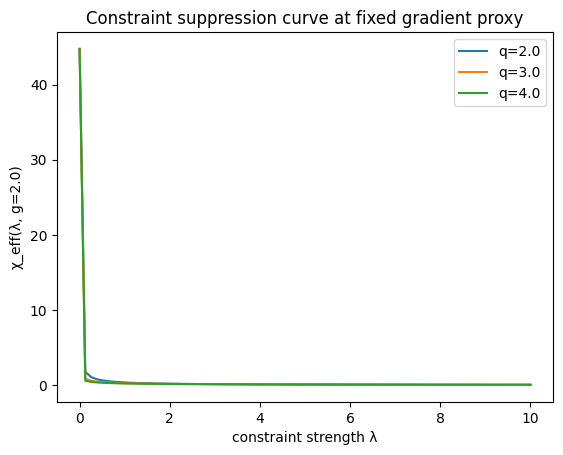

In [21]:
g_star = 2.0
lam_vals = np.linspace(0, 10, 80)

for Q in [2.0, 3.0, 4.0]:
    chi_vals = [chi_eff(lam, g_star, beta=1.8, q=Q) for lam in lam_vals]
    plt.plot(lam_vals, chi_vals, label=f"q={Q}")

plt.xlabel("constraint strength λ")
plt.ylabel(f"χ_eff(λ, g={g_star})")
plt.title("Constraint suppression curve at fixed gradient proxy")
plt.legend()
plt.show()

In [22]:
def elasticity_g(lam, g, eps=1e-3, beta=1.8, q=3.0):
    c1 = chi_eff(lam, g*(1-eps), beta=beta, q=q)
    c2 = chi_eff(lam, g*(1+eps), beta=beta, q=q)
    return (np.log(c2) - np.log(c1)) / (np.log(g*(1+eps)) - np.log(g*(1-eps)))

g_star = 2.0
q_main = 3.0

print("Metrics at fixed gradient proxy g* =", g_star, "with q =", q_main)
for lam in [0, 0.5, 1, 2, 5, 10]:
    chi0 = chi_eff(lam, g_star, beta=1.8, q=q_main)
    Eg  = elasticity_g(lam, g_star, beta=1.8, q=q_main)
    print(f"λ={lam:>4}: χ_eff={chi0:.6g}, elasticity_Eg={Eg:.3f}")

Metrics at fixed gradient proxy g* = 2.0 with q = 3.0
λ=   0: χ_eff=44.7317, elasticity_Eg=3.600
λ= 0.5: χ_eff=0.425353, elasticity_Eg=0.572
λ=   1: χ_eff=0.286948, elasticity_Eg=0.515
λ=   2: χ_eff=0.193479, elasticity_Eg=0.542
λ=   5: χ_eff=0.114568, elasticity_Eg=0.482
λ=  10: χ_eff=0.0771469, elasticity_Eg=0.566
